# Análise de movimento de estações de aluguel de bicicleta

Nesse notebook, utilizaremos [dados de aluguel de bicicleta em Austin](https://www.kaggle.com/jboysen/austin-bike), e analisaremos o movimento (chegada e saída de bicicletas) nas estações com gráficos e *machine learning*.

Utilizaremos gráficos para identificar as estações de aluguel mais ativas e fazer uma análise temporal das movimentações, obtendo as estações do ano e horários do dia mais movimentados. No final, aplicaremos o **RandomForestRegressor()** da biblioteca scikit-learn para fazer uma predição da movimentação nos meses seguintes da base de dados.

Para isso, seguiremos as etapas:
* Leitura da base de dados e modelagem inicial; 
* Geração de gráficos para uma análise visual dos dados;
* Previsão dos próximos 5 meses, com base nos dados existentes.


Antes de tudo, precisamos importar a base e analisar o estado dos dados.

In [17]:
## importação das bibliotecas utilizadas
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.dates import  DateFormatter, DayLocator
from matplotlib.ticker import PercentFormatter
from datetime import datetime
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics

plt.style.use('default')

In [18]:
## importação das databases dos csvs
stations_csv = pd.read_csv('./austin_bikeshare_stations.csv')
trips_csv = pd.read_csv('./austin_bikeshare_trips.csv')

stations_active = stations_csv.query("status != 'closed' & status != 'moved'")

In [19]:
stations_csv

,latitude,location,longitude,name,station_id,status
0,30.27041,(30.27041 -97.75046),-97.75046,West & 6th St.,2537,active
1,30.26452,(30.26452 -97.7712),-97.77120,Barton Springs Pool,2572,active
2,30.27595,(30.27595 -97.74739),-97.74739,ACC - Rio Grande & 12th,2545,closed
3,30.28480,(30.2848 -97.72756),-97.72756,Red River & LBJ Library,1004,closed
4,30.26694,(30.26694 -97.74939),-97.74939,Nueces @ 3rd,1008,moved
...,...,...,...,...,...,...
67,30.26634,(30.26634 -97.74378),-97.74378,4th & Congress,2495,active
68,30.26780,(30.2678 -97.75189),-97.75189,3rd & West,2552,active
69,30.26960,(30.2696 -97.75332),-97.75332,5th & Bowie,2501,active
70,30.26416,(30.26416 -97.73289),-97.73289,5th & San Marcos,2564,moved


In [20]:
trips_csv

,bikeid,checkout_time,duration_minutes,end_station_id,end_station_name,month,start_station_id,start_station_name,start_time,subscriber_type,trip_id,year
0,8.0,19:12:00,41,2565.0,Trinity & 6th Street,3.0,2536.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0
1,141.0,2:06:04,6,2570.0,South Congress & Academy,10.0,2494.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0
2,578.0,16:28:27,13,2498.0,Convention Center / 4th St. @ MetroRail,3.0,2538.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0
3,555.0,15:12:00,80,2712.0,Toomey Rd @ South Lamar,11.0,2497.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0
4,86.0,15:39:13,25,3377.0,MoPac Pedestrian Bridge @ Veterans Drive,4.0,2707.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...
649226,52.0,0:12:00,90,2571.0,Red River & 8th Street,7.0,2544.0,East 6th & Pedernales St.,2014-07-06 00:12:00,24-Hour Kiosk (Austin B-cycle),9900185926,2014.0
649227,104.0,17:20:44,53,2499.0,City Hall / Lavaca & 2nd,2.0,3619.0,6th & Congress,2017-02-06 17:20:44,Walk Up,13649794,2017.0
649228,240.0,13:12:55,44,2495.0,4th & Congress,11.0,2495.0,4th & Congress,2015-11-18 13:12:55,Walk Up,9900329990,2015.0
649229,421.0,14:45:34,106,2494.0,2nd & Congress,5.0,2494.0,2nd & Congress,2016-05-29 14:45:34,Try Before You Buy Special,10219003,2016.0


Visualizando os *datasets*, podemos fazer algumas observações:
* Na base com os dados das viagens, os campos 'start_station_id' e 'end_station_id' possuem uma casa decimal desnecessária;
* Existem linhas com valores vazios para 'start_station_id' e 'end_station_id';
* Existem estações inativas (status 'closed') e que mudaram de lugar (status 'moved');
* Como iremos prever o movimento de cada estação, existem campos que não nos interessam. Utilizaremos apenas 'end_station_id', 'start_station_id', 'start_time' e 'end_time'.

Então, vamos tratar a nossa base para resolver esses problemas e criar um *dataset* mais limpo.

In [21]:
trips_temp = trips_csv.copy()
trips = pd.DataFrame()

## retirando as linhas que possuem 'end_station_id' e 'start_station_id' nulas
trips_temp = trips_temp[(np.isnan(trips_temp['end_station_id']) == False) &
                        (np.isnan(trips_temp['start_station_id']) == False)] #dropna

## criando um dataframe mais compacto, e retirando as casas decimais dos IDs
trips['end_station_id'] = trips_temp['end_station_id'].astype('int')
trips['start_station_id'] = trips_temp['start_station_id'].astype('int')
trips['start_time'] = pd.to_datetime(trips_temp['start_time'])
trips['end_time'] = trips['start_time'] + pd.to_timedelta(trips_temp['duration_minutes'], unit='min')

## filtando o dataframe para só conter as viagens que começam e terminam nas estações ativas
active = stations_active['station_id']
trips = trips.query("end_station_id in @active & start_station_id in @active")

trips

,end_station_id,start_station_id,start_time,end_time
1,2570,2494,2016-10-30 02:06:04,2016-10-30 02:12:04
2,2498,2538,2016-03-11 16:28:27,2016-03-11 16:41:27
4,3377,2707,2017-04-16 15:39:13,2017-04-16 16:04:13
5,2537,2540,2015-05-29 15:12:00,2015-05-29 15:41:00
6,2575,2567,2016-07-26 12:24:16,2016-07-26 12:41:16
...,...,...,...,...
649225,3377,2575,2016-05-09 15:56:11,2016-05-09 16:12:11
649226,2571,2544,2014-07-06 00:12:00,2014-07-06 01:42:00
649227,2499,3619,2017-02-06 17:20:44,2017-02-06 18:13:44
649228,2495,2495,2015-11-18 13:12:55,2015-11-18 13:56:55


Agora sim, temos uma base mais limpa, mas ainda não exatamente no modelo que precisamos. Como nosso interesse é em analisar a movimentação, faz mais sentido observar um campo que une as chegadas e saídas em cada estação. 

Então, criaremos um novo *dataset*, que terá um relatório de movimentações (entrada e saída) por estação.

In [22]:
movement = pd.DataFrame()
movement['station_id'] = trips['end_station_id'].astype('str')
movement['date'] = trips['end_time'].dt.date
movement['year'] = trips['end_time'].dt.year
movement['month'] = trips['end_time'].dt.month
movement['hour_of_day'] = trips['end_time'].dt.hour
tmp_month_start = movement['year'].astype('str') + '/' + movement['month'].astype('str')
movement['month_start'] = pd.to_datetime(tmp_month_start, format='%Y/%m')

temp_movement = pd.DataFrame()
temp_movement['station_id'] = trips['start_station_id'].astype('str')
temp_movement['date'] = trips['start_time'].dt.date
temp_movement['year'] = trips['start_time'].dt.year
temp_movement['month'] = trips['start_time'].dt.month
temp_movement['hour_of_day'] = trips['start_time'].dt.hour
tmp_month_start = temp_movement['year'].astype('str') + '/' + temp_movement['month'].astype('str')
temp_movement['month_start'] = pd.to_datetime(tmp_month_start, format='%Y/%m')

movement = movement.append(temp_movement, ignore_index=True)
movement = movement.sort_values(['date'])
movement.reset_index(drop=True, inplace=True)

movement

,station_id,date,year,month,hour_of_day,month_start
0,2501,2013-12-21,2013,12,15,2013-12-01
1,2496,2013-12-21,2013,12,16,2013-12-01
2,2497,2013-12-21,2013,12,9,2013-12-01
3,2494,2013-12-21,2013,12,16,2013-12-01
4,2497,2013-12-21,2013,12,16,2013-12-01
...,...,...,...,...,...,...
1058597,2575,2017-07-31,2017,7,12,2017-07-01
1058598,2567,2017-07-31,2017,7,9,2017-07-01
1058599,2569,2017-07-31,2017,7,17,2017-07-01
1058600,2552,2017-07-31,2017,7,17,2017-07-01


Finalmente, temos um modelo de dados adequado para o que precisamos. Agora, podemos gerar alguns gráficos para analisar os dados e tirar conclusões sobre os aluguéis de bicicleta.

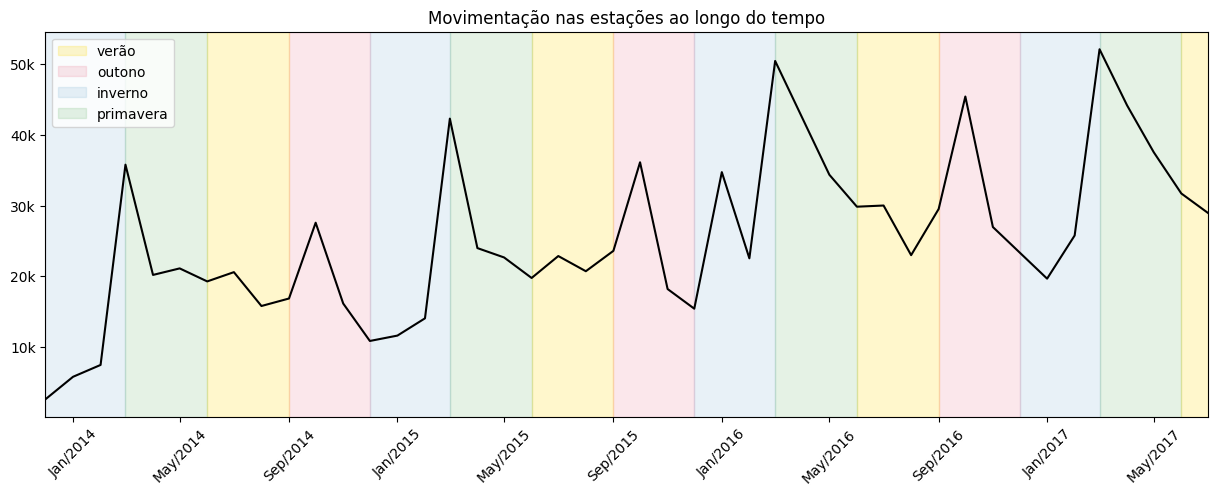

In [23]:
## criação de gráfico de linha do tempo, demarcando as estações do ano

fig, ax = plt.subplots(figsize=(15,5))
## gráfico de linha, mostrando as movimentações ao longo do tempo
plt.plot(movement[['month_start','station_id']].groupby('month_start').count(), color='black')
plt.title('Movimentação nas estações ao longo do tempo')
plt.xticks(rotation=45)
ax.set_xlim(movement['month_start'][0],movement['month_start'].tail(1))
ax.xaxis.set_major_formatter(DateFormatter("%b/%Y"))
ax.yaxis.set_major_formatter(lambda x , pos: str(int(x/1000))+'k')

## colorir o fundo do gráfico de acordo com as estações do ano
years = movement['year'].unique()
for y in years:
    i = list(years).index(y)
    summer_start = str(y)+'-06-01'
    summer_end = str(y)+'-09-01'
    plt.axvspan(summer_start,summer_end, color='gold',label='_'*i+'verão', alpha=0.2)
    fall_start = str(y)+'-09-01'
    fall_end = str(y)+'-12-01'
    plt.axvspan(fall_start,fall_end, color='crimson',label='_'*i+'outono', alpha=0.1)
    winter_start = str(y)+'-12-01'
    winter_end = str(y+1)+'-03-01'
    plt.axvspan(winter_start,winter_end, color='tab:blue',label='_'*i+'inverno', alpha=0.1)
    spring_start = str(y)+'-03-01'
    spring_end = str(y)+'-06-01'
    plt.axvspan(spring_start,spring_end, color='green',label='_'*i+'primavera', alpha=0.1)
plt.legend()
plt.show()

A partir da visão temporal das movimentações, conseguimos identificar quando ocorre um crescimento na quantidade de aluguéis. Também conseguimos perceber que a movimentação das estações tem aumentado ao longo dos anos

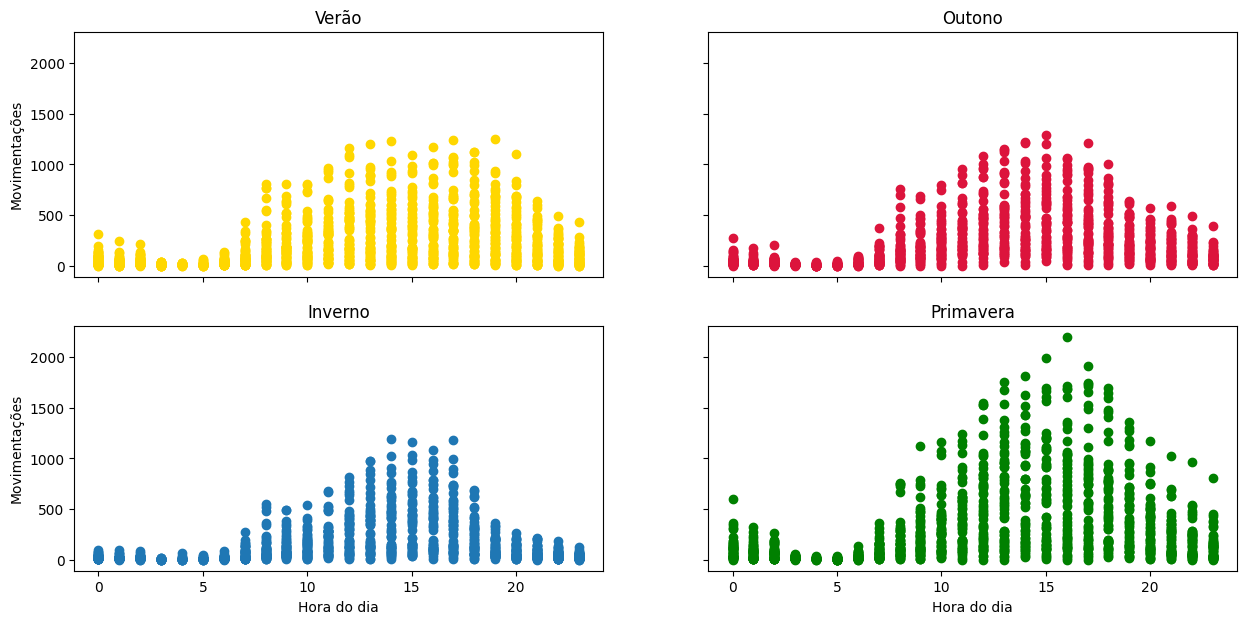

In [24]:
## criação de gráficos de dispersão, que mostram a movimentação ao longo do dia, em cada estação do ano

summer_months = [6,7,8]
fall_months = [9,10,11]
winter_months = [12,1,2]
spring_months = [3,4,5]

summer_mov = movement[['station_id','hour_of_day','month']].query("month in @summer_months")
summer_mov = summer_mov.groupby(['station_id','hour_of_day'], as_index=False).count()
summer_mov = summer_mov.rename(columns={'month':'count'})

fall_mov = movement[['station_id','hour_of_day','month']].query("month in @fall_months")
fall_mov = fall_mov.groupby(['station_id','hour_of_day'], as_index=False).count()
fall_mov = fall_mov.rename(columns={'month':'count'})

winter_mov = movement[['station_id','hour_of_day','month']].query("month in @winter_months")
winter_mov = winter_mov.groupby(['station_id','hour_of_day'], as_index=False).count()
winter_mov = winter_mov.rename(columns={'month':'count'})

spring_mov = movement[['station_id','hour_of_day','month']].query("month in @spring_months")
spring_mov = spring_mov.groupby(['station_id','hour_of_day'], as_index=False).count()
spring_mov = spring_mov.rename(columns={'month':'count'})

fig, ax = plt.subplots(2,2,figsize=(15,7), sharex=True, sharey=True)
ax[0,0].scatter(summer_mov['hour_of_day'],summer_mov['count'], color='gold')
ax[0,0].set_title('Verão')
ax[0,1].scatter(fall_mov['hour_of_day'],fall_mov['count'], color='crimson')
ax[0,1].set_title('Outono')
ax[1,0].scatter(winter_mov['hour_of_day'],winter_mov['count'], color='tab:blue')
ax[1,0].set_title('Inverno')
ax[1,1].scatter(spring_mov['hour_of_day'],spring_mov['count'], color='green')
ax[1,1].set_title('Primavera')

for ax in fig.get_axes():
    ax.set(xlabel='Hora do dia', ylabel='Movimentações')
    ax.label_outer()
    
plt.show()

Com esses gráficos de dispersão, podemos ver, claramente, que a movimentação se concentra nos horários da tarde e começo da noite. Também vemos que a primavera é a estação do ano na qual ocorrem mais movimentações. 

Com essa visão, já conseguimos criar uma diretriz de quanto cobrar pelo espaço publicitário de acordo com a hora do dia. 

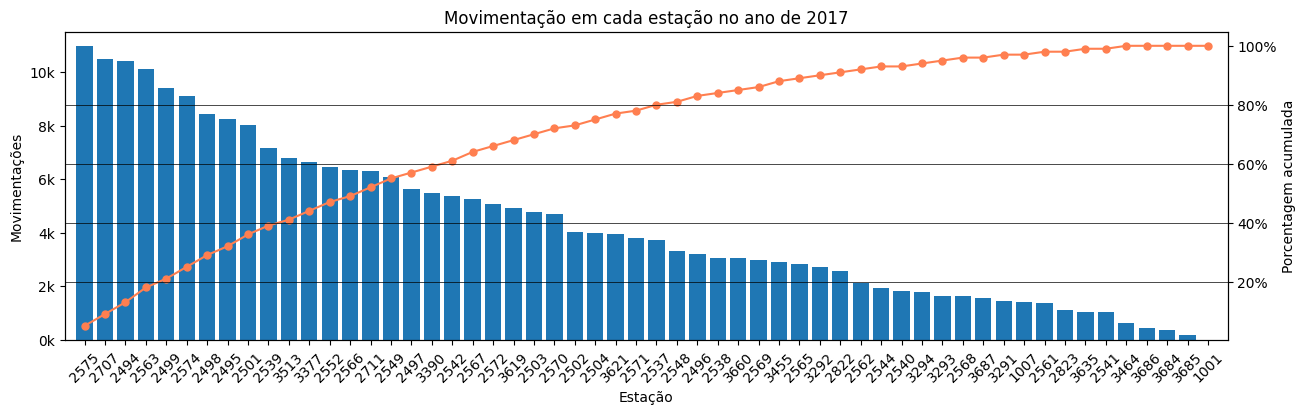

In [25]:
## criação de gráfico de pareto

mov_pareto = movement[['station_id','year','month']].groupby(['year','station_id'], as_index=False).count()
mov_pareto = mov_pareto.rename(columns={'month':'count'})
mov_pareto = mov_pareto.sort_values(['year','count'], ascending=False)
mov_pareto = mov_pareto.query("year==2017")[['station_id','count']]
mov_pareto['percentage'] = round(mov_pareto['count'].cumsum()/mov_pareto['count'].sum()*100)

fig, ax = plt.subplots(figsize=(15,4))
ax.bar(mov_pareto['station_id'],mov_pareto['count'], width= 0.8)
ax.set_xlabel("Estação")
ax.set_ylabel("Movimentações")
ax.yaxis.set_major_formatter(lambda x , pos: str(int(x/1000))+'k')

ax2 = ax.twinx()
ax2.plot(mov_pareto['station_id'],mov_pareto['percentage'], color='coral',marker="o", ms=5)
ax2.axhline(20, color="k", linestyle="-", lw="0.5")
ax2.axhline(40, color="k", linestyle="-", lw="0.5")
ax2.axhline(60, color="k", linestyle="-", lw="0.5")
ax2.axhline(80, color="k", linestyle="-", lw="0.5")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Porcentagem acumulada")

for ax in fig.get_axes():
    ax.tick_params('x', labelrotation=45)
    ax.margins(x=0.01)

plt.title('Movimentação em cada estação no ano de 2017')
plt.show()

Nesse último gráfico, conseguimos identificar as estações que concentram determinadas porcentagens do total de movimentações. Podemos ver, por exemplo, que as estações de ID 2575, 2707, 2494 e 2563 concentram quase 20% da movimentação total. 

In [26]:
# estações que concentram x% das movimentações

top20_stations = mov_pareto.query("percentage<=20")['station_id'].values.tolist()
top40_stations = mov_pareto.query("percentage<=40")['station_id'].values.tolist()
top60_stations = mov_pareto.query("percentage<=60")['station_id'].values.tolist()
top80_stations = mov_pareto.query("percentage<=80")['station_id'].values.tolist()

## Fazendo a predição de movimentações

Antes de tudo, vamos ajustar mais uma vez o modelo para ficar em um formato adequado para fazermos as predições. 

Como vimos pelas análises gráficas que a quantidade de movimentos é bastante influenciada pela data, estação do ano e ponto de aluguel, utilizaremos como *features* do nosso modelo os campos 'station_id', 'month_start', 'month' e 'season'.

Além disso, vamos concentrar a predição nas estações que correspondem a 80% das movimentações de aluguel.

In [27]:
## criando a base para as predições

db = movement.query("station_id in @top80_stations")
db = db.groupby(['year','month_start','month','station_id'], as_index=False).count()
db['station_id'] = db['station_id'].astype('int')
db = db.drop(columns='hour_of_day')
db['month_start'] = db['month_start'].apply(datetime.toordinal)
seasons = [1,2,3,4] # winter = 1, spring = 2, summer = 3, fall = 4
db['season'] = db['month'].apply(lambda x: seasons[int(np.ceil((x+1)/3)-1)] if x != 12 else 1)
db = db.rename(columns={'date':'count'})

db.head(5)

,year,month_start,month,station_id,count,season
0,2013,735203,12,2494,210,1
1,2013,735203,12,2495,243,1
2,2013,735203,12,2497,468,1
3,2013,735203,12,2498,145,1
4,2013,735203,12,2499,312,1


Agora que temos a base completa, precisamos separar os dados de treino e de teste. Utilizaremos como treino os dados anteriores a 2017 e testaremos o modelo com os dados deste ano.

In [28]:
train = db.query("year != 2017").drop(columns='year')
X_train = train.drop(columns='count')
y_train = train['count']

test = db.query("year == 2017").drop(columns='year')
X_test = test.drop(columns='count')
y_test = test['count']

Antes de fazer a predição, criamos funções para ajudar a avaliar o resultado da predição

In [34]:
## função utilizada para plotar os resultados da predição junto com os dados da base

def plot_result(db, X_test, pred_values):
    actual = db.copy()
    pred = X_test.copy()
    pred['count'] = pred_values
    
    actual['month_start'] = actual['month_start'].apply(lambda x: datetime.fromordinal(x))
    actual = actual[['month_start','count']].groupby('month_start', as_index=False).sum()
    
    pred['month_start'] = pred['month_start'].apply(lambda x: datetime.fromordinal(x))
    pred = pred[['month_start','count']].groupby('month_start', as_index=False).sum()
    
    fig, ax = plt.subplots(figsize=(15,5))
    plt.plot(actual['month_start'], actual['count'], label='Valor real')
    plt.plot(pred['month_start'], pred['count'], label='Valor previsto')
    ax.yaxis.set_major_formatter(lambda x , pos: str(int(x/1000))+'k')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.title('Movimentação nas estações ao longo do tempo')
    plt.legend(loc='lower right')
    plt.show()

In [35]:
## função utilizada para mostrar as métricas de desempenho

def show_metrics(actual, pred):
    print('MAE: {:.2f}'.format(metrics.mean_absolute_error(actual,pred)))
    print('MAPE: {:.2f}%'.format(metrics.mean_absolute_percentage_error(actual,pred)*100))
    print('r2 score: {:.2f}'.format(metrics.r2_score(actual,pred)))

Finalmente, faremos a predição. Para isso, vamos usar o algorítmo **RandomForestRegressor()**, presente na biblioteca *sklearn*. O único hiperparâmetro que definiremos será o n_estimators (número de árvores), com valor 100.

In [36]:
rf = RandomForestRegressor(n_estimators=100)

rf.fit(X_train,y_train)
pred = np.rint(rf.predict(X_test))

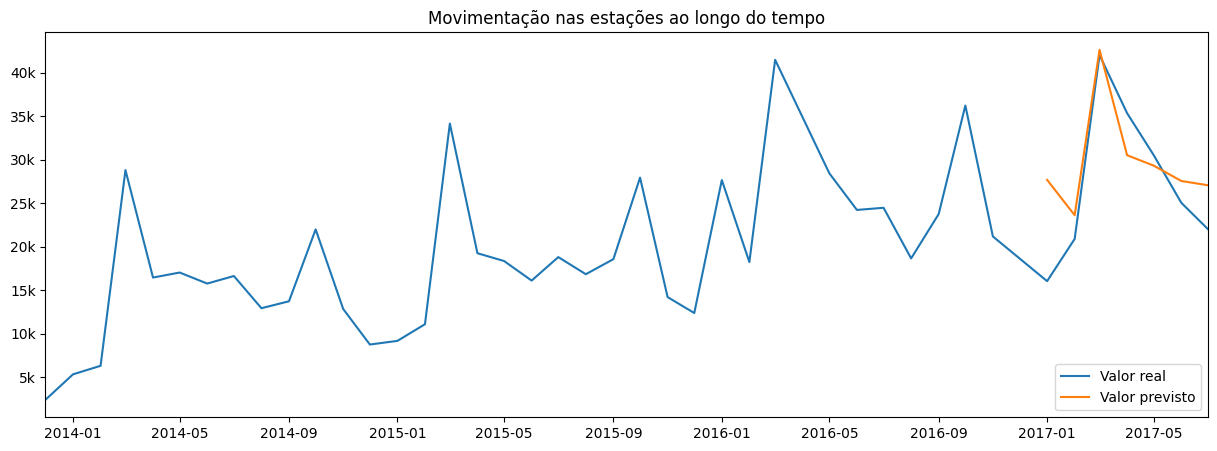

In [37]:
plot_result(db, X_test, pred)

In [38]:
show_metrics(y_test, pred)

MAE: 197.96
MAPE: 26.76%
r2 score: 0.70


O MAE (Mean Absolute Error) indica uma média para todos os registros do erro entre o valor previsto e o valor real. O MAPE (Mean Absolute Percentage Error) tem um significado parecido, indicando a média para todos os registros da razão entre o erro e o valor real. Já o r² score indica a correlação entre os valores previsto e real (quanto mais perto de 1, maior a correlação).

Para tentar obter resultados melhores, outras modelagens foram testadas, com o mesmo método de previsão. Na tabela abaixo, vemos o resultado desses testes:

|                        Features                         |   MAE  |  MAPE  | R2 SCORE |
|:-------------------------------------------------------:|:------:|:------:|:--------:|
| month_start, month, station_id, season                  | 191.37 | 25.71% |   0.72   |
| month, station_id, season                               | 217.62 | 25.29% |   0.64   |
| month, station_id, season, month -1, month -2, month -3 | 240.82 | 32.04% |    0.5   |
| month, season, month -1, month -2, month -3             | 259.18 | 33.08% |   0.43   |
| month, station_id, season, avg 3 months                 | 234.25 | 30.79% |   0.55   |
| month, season, avg 3 months                             | 275.91 | 35.62% |   0.32   |
| month, station_id, season, year -1, year -2             | 313.11 | 50.01% |   0.11   |

Como estamos tratando de uma série temporal, poderíamos obter resultados melhores utilizando técnicas de predição e modelagem específicas para esse tipo de dado. No entanto, conhecendo nossos dados, com as métricas e o gráfico apresentados podemos concluir que, ainda que não esteja perfeito, nosso modelo é bom o suficiente para prever as movimentações nas estações de aluguel.

Até agora, ainda não exploramos nada além do que já conhecíamos. Então, vamos expandir a base X_test para os meses seguintes e, assim, obter uma predição que indique a movimentação até o final de 2017. Visualizamos esse resultado no gráfico a seguir.

In [39]:
pred_months = ['2017-08-01','2017-09-01','2017-10-01','2017-11-01','2017-12-01']
future = pd.DataFrame(data={'month_start':pred_months})
future['month_start'] = pd.to_datetime(future['month_start'])
future['month'] = future['month_start'].dt.month
future['season'] = future['month'].apply(lambda x: seasons[int(np.ceil((x+1)/3)-1)] if x != 12 else 1)
future['month_start'] = future['month_start'].apply(datetime.toordinal)

future = future.merge(pd.DataFrame({'station_id':top80_stations}), how='cross')
future['station_id'] = future['station_id'].astype('int')

X_ext = X_test.append(future, ignore_index=True)

In [40]:
pred_ext = np.rint(rf.predict(X_ext))

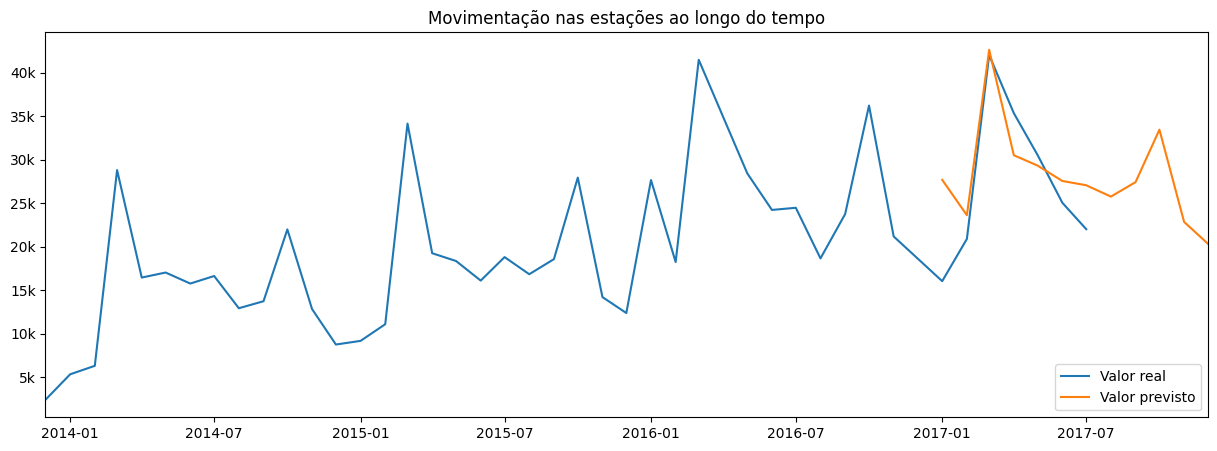

In [41]:
plot_result(db, X_ext, pred_ext)

In [42]:
print('Estimativa de movimentações até o final de 2017: {:d}k'.format(int((pred_ext.sum()-pred.sum())/1000)))

Estimativa de movimentações até o final de 2017: 129k


Com isso, concluímos que haverá cerca de 130 mil movimentações nas estações de aluguel de bibicleta entre agosto e dezembro de 2017.